<a href="https://colab.research.google.com/github/Blaze10/DL/blob/main/regularization/dropout_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

## Separate the data into dataloaders

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=16)
test_loader = DataLoader(test_data, batch_size=len(test_data))

## Create a model and training regimen

In [4]:
class ANNClassifyModel(nn.Module):
  def __init__(self, dropoutRate):
    super(ANNClassifyModel, self).__init__()
    self.input = nn.Linear(4, 12)
    self.hidden = nn.Linear(12,12)
    self.output = nn.Linear(12, 3)
    self.dr = dropoutRate

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = self.output(x)
    return x

In [5]:
# test the model
tempnet = ANNClassifyModel(.25)
tmpdata = torch.rand((10,4))
yhat = tempnet(tmpdata)
yhat

tensor([[ 0.1889,  0.1015, -0.1886],
        [ 0.1039,  0.1594, -0.1939],
        [ 0.2124,  0.0969, -0.1493],
        [ 0.1120, -0.2190,  0.0093],
        [ 0.0392, -0.1049, -0.0167],
        [ 0.3099, -0.0655, -0.0530],
        [ 0.0293,  0.0891, -0.0443],
        [ 0.3678,  0.1323, -0.2361],
        [ 0.1465, -0.0206,  0.1400],
        [ 0.2971,  0.1252,  0.0150]], grad_fn=<AddmmBackward0>)

In [6]:
# function that creates the model
def create_model(dropoutRate):
  ANNClassify = ANNClassifyModel(dropoutRate)
  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNClassify.parameters(), lr=.005)
  return ANNClassify, loss_fun, optimizer

In [7]:
# train the model
num_epochs = 500
def train_model(ANNClassify, loss_fun, optimizer):
  train_acc = []
  test_acc = []

  for epochi in range(num_epochs):
    ANNClassify.train()
    batch_acc = []
    for x,y in train_loader:
      yHat = ANNClassify(x)
      loss = loss_fun(yHat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    
    train_acc.append(np.mean(batch_acc))

    # test accuracy
    ANNClassify.eval()
    x,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNClassify(x), axis=1)
    test_acc.append(100 * torch.mean((predlabels == y).float()).item())

  return train_acc, test_acc

In [8]:
dropoutRate = 0
ANNClassify, loss_fun, optimizer = create_model(dropoutRate)
train_acc, test_acc = train_model(ANNClassify, loss_fun, optimizer)

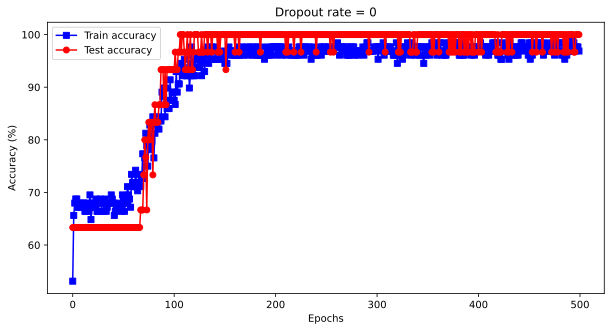

In [9]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_acc, 'bs-')
plt.plot(test_acc, 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.title(f'Dropout rate = {dropoutRate}')
plt.show()

## Running the experiment

In [10]:
dropoutRates = np.arange(10) / 10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):
  ANNClassify, loss_fun, optimizer = create_model(dropoutRates[di])
  train_acc, test_acc = train_model(ANNClassify, loss_fun, optimizer)

  results[di,0] = np.mean(train_acc[-50:])
  results[di,1] = np.mean(test_acc[-50:])

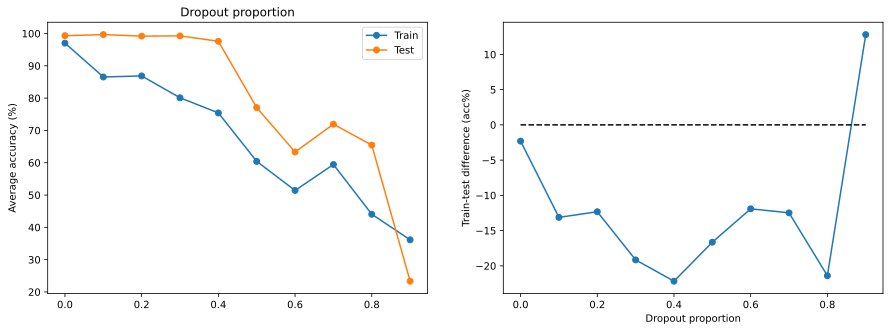

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_title('Dropout proportion')
ax[0].set_ylabel('Average accuracy (%)')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0,.9],[0,0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')
plt.show()